# Classification using a Neural Network - Handle Class Imbalance (Pytorch)
The dataset is from https://www.kaggle.com/c/GiveMeSomeCredit <br>
"Banks play a crucial role in market economies. They decide who can get finance and on what terms and can make or break investment decisions. For markets and society to function, individuals and companies need access to credit. Credit scoring algorithms, which make a guess at the probability of default, are the method banks use to determine whether or not a loan should be granted."  <br>
We will build an MLP classifier to predict if someone will experience financial distress and therefore cannot pay off credit card (i.e. default). It is a binary classificaiton problem: default (class-1) or not default  (class-0) <br>
Real dataset is often imbalanced: class-i may have much more data samples than class-j.

In [1]:
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
import pandas as pd
import torch

### Load the data

In [2]:
#every row of the table is a data sample (feature vector) from a person
df = pd.read_csv('cs_data.csv')
df.head()

,id,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


#### handle nan (null) in data (i.e. missing values)
Some fields in the table are nan, which are missing values. <br>
For example, someone may not want to reveal monthly income to whoever made the table/survey, then the table got nan.

In [3]:
df.isnull().sum()

id                                          0
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

In [4]:
#here, we use a simple method:
#replace nan in each column with median value of that column
#there are other methods in pandas and sklearn: interpolation in pandas and KNNImputer in sklearn
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
dfv=imputer.fit_transform(df.values)
df=pd.DataFrame(data=dfv, columns=df.columns)
df.isnull().sum()

id                                      0
SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64

### We have a highly imbalanced dataset
139974 data samples in class-0 (normal) <br>
10026 data samples in class-1 (financial distress)

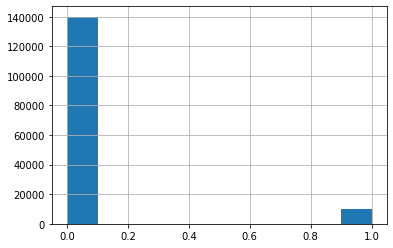

In [5]:
df['SeriousDlqin2yrs'].hist()

#### Classification Goal: predict 'SeriousDlqin2yrs' (Y) using the other features (X)

In [6]:
#'SeriousDlqin2yrs' is the target/class label, so it should not be in the input feature vector X
#'id' of a person is useless for the classification task
#so, we remove them from the table and get the input X
X=df.drop(['SeriousDlqin2yrs', 'id'], axis=1)
X.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0.766127,45.0,2.0,0.802982,9120.0,13.0,0.0,6.0,0.0,2.0
1,0.957151,40.0,0.0,0.121876,2600.0,4.0,0.0,0.0,0.0,1.0
2,0.658180,38.0,1.0,0.085113,3042.0,2.0,1.0,0.0,0.0,0.0
3,0.233810,30.0,0.0,0.036050,3300.0,5.0,0.0,0.0,0.0,0.0
4,0.907239,49.0,1.0,0.024926,63588.0,7.0,0.0,1.0,0.0,0.0


In [7]:
#Y is the target/class label
Y=df['SeriousDlqin2yrs']
Y.head()

0    1.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: SeriousDlqin2yrs, dtype: float64

In [8]:
# convert pandas dataframe/series to numpy array
# sklearn functions may not work well with pandas data types
X=X.values
Y=Y.values

### create training, validation and test sets

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
#split X_train and Y_train into a 'pure' training set and a validation set
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=0)
print('train:', X_train.shape, Y_train.shape)
print('validation:', X_val.shape, Y_val.shape)
print('test:', X_test.shape, Y_test.shape)

train: (108000, 10) (108000,)
validation: (12000, 10) (12000,)
test: (30000, 10) (30000,)


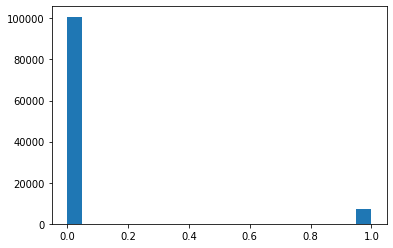

In [10]:
plt.hist(Y_train, bins=20);

Let's do upsampling for class-1

In [11]:
from sklearn.utils import resample
X_train_c1  = resample(X_train[Y_train==1], n_samples=100824)
Y_train_c1 = np.ones(X_train_c1.shape[0])
print('X_train_c1', X_train_c1.shape, Y_train_c1.shape)
X_train=np.concatenate([X_train[Y_train==0], X_train_c1], axis=0)
Y_train=np.concatenate([Y_train[Y_train==0], Y_train_c1], axis=0)
print('X_train.shape after upsampling', X_train.shape)
print('Y_train.shape after upsampling', Y_train.shape)

X_train_c1 (100824, 10) (100824,)
X_train.shape after upsampling (201648, 10)
Y_train.shape after upsampling (201648,)


In [12]:
#apply feature normalization to training, validation and test sets
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaler.fit(X_train) # think about why fit to X_train, not X ?
X_train=scaler.transform(X_train)
X_val=scaler.transform(X_val)
X_test=scaler.transform(X_test)

In [13]:
# we need to use weighted classification accuracy
# try to understand it
def weighted_accuracy(confusion):
    #input: confusion is the confusion matrix
    #output: acc is the weighted classification accuracy
    M=confusion.copy().astype('float32')
    for k in range(0, M.shape[0]):
        M[k]/=M[k].sum()+1e-8    
    acc = M.diagonal().sum()/M.sum()
    return acc

## Your task begins here <br>
see NN_binary_classification_Pytorch.ipynb in Lecture 16 <br>
try Adma with lr=0.001 <br>
Usually, we need to tune the hyperparameters of a neural network, <br>
such as the number of layers, the number of units in each layer <br>
If you have plenty of time and enough computing power, try to find better hyperparameters <br>
read papers about "Neural Architecture Search" https://arxiv.org/abs/1808.05377 <br>

You need to modify the function `test` in order to use weighted_accuracy, see `test_acc` in H3P2T1_Keras.ipynb

### define a dataset to hold/represent the data 

Create instance objects of the `MyDataset` class <br>
a training dataset `dataset_train` <br>
a validation dataset `dataset_val` <br>
a testing dataset `dataset_test` <br>

In [16]:
# get the first data point in the training set
# dataset_train[0][0] is x0
# dataset_train[0][1] is y0
dataset_train[0][0].shape

torch.Size([10])

In [17]:
# the class label of the first training sample x0
dataset_train[0][1]

tensor(0.)

In [18]:
len(dataset_train) # get the number of data points in the training set

201648

### Create dataloaders which will be used to generate minibatches
batch_size=N means each minibatch contains N data points  <br>
note: the last minibatch may contain less than N data points

In [19]:
#we must shuffle data points in the training set, set shuffle=True


In [20]:
len(dataloader_train) # get the number of minibatches

3151

### Now, let's build a neural network that does binary classification

create an instance object of the class

In [23]:
#move the model to GPU if you have a GPU


Net(
  (layer1): Linear(in_features=10, out_features=256, bias=True)
  (layer2): Linear(in_features=256, out_features=256, bias=True)
  (layer3): Linear(in_features=256, out_features=256, bias=True)
  (layer4): Linear(in_features=256, out_features=1, bias=True)
)

create an optimizer (e.g. Adam) and send the parameters of the model to the optimizer

define a function to train the neural network in one epoch

define a function to evaluate the neural network on the validation set or the testing set

define a function to save the model to a file

define a function to load the model from a file

train the neural network model for many epochs

Train Epoch: 0 [0/201648 (0%)]	Loss: 0.692816
Train Epoch: 0 [6400/201648 (3%)]	Loss: 0.620332
Train Epoch: 0 [12800/201648 (6%)]	Loss: 0.673153
Train Epoch: 0 [19200/201648 (10%)]	Loss: 0.602169
Train Epoch: 0 [25600/201648 (13%)]	Loss: 0.574649
Train Epoch: 0 [32000/201648 (16%)]	Loss: 0.443933
Train Epoch: 0 [38400/201648 (19%)]	Loss: 0.481559
Train Epoch: 0 [44800/201648 (22%)]	Loss: 0.577212
Train Epoch: 0 [51200/201648 (25%)]	Loss: 0.486503
Train Epoch: 0 [57600/201648 (29%)]	Loss: 0.440227
Train Epoch: 0 [64000/201648 (32%)]	Loss: 0.424436
Train Epoch: 0 [70400/201648 (35%)]	Loss: 0.516994
Train Epoch: 0 [76800/201648 (38%)]	Loss: 0.441609
Train Epoch: 0 [83200/201648 (41%)]	Loss: 0.459680
Train Epoch: 0 [89600/201648 (44%)]	Loss: 0.466487
Train Epoch: 0 [96000/201648 (48%)]	Loss: 0.573463
Train Epoch: 0 [102400/201648 (51%)]	Loss: 0.514662
Train Epoch: 0 [108800/201648 (54%)]	Loss: 0.402093
Train Epoch: 0 [115200/201648 (57%)]	Loss: 0.564527
Train Epoch: 0 [121600/201648 (60%)]

Train Epoch: 4 [134400/201648 (67%)]	Loss: 0.616271
Train Epoch: 4 [140800/201648 (70%)]	Loss: 0.488345
Train Epoch: 4 [147200/201648 (73%)]	Loss: 0.402225
Train Epoch: 4 [153600/201648 (76%)]	Loss: 0.379644
Train Epoch: 4 [160000/201648 (79%)]	Loss: 0.573850
Train Epoch: 4 [166400/201648 (83%)]	Loss: 0.419749
Train Epoch: 4 [172800/201648 (86%)]	Loss: 0.542373
Train Epoch: 4 [179200/201648 (89%)]	Loss: 0.515818
Train Epoch: 4 [185600/201648 (92%)]	Loss: 0.615233
Train Epoch: 4 [192000/201648 (95%)]	Loss: 0.503362
Train Epoch: 4 [198400/201648 (98%)]	Loss: 0.508732
epoch 4 training loss: 0.49528386497527827 acc: 0.7667619
epoch 4 validation loss: 0.5505949737543755 acc: 0.75961196
saved: H3P2T1_Pytorch_e4.pt
Train Epoch: 5 [0/201648 (0%)]	Loss: 0.480408
Train Epoch: 5 [6400/201648 (3%)]	Loss: 0.568960
Train Epoch: 5 [12800/201648 (6%)]	Loss: 0.398670
Train Epoch: 5 [19200/201648 (10%)]	Loss: 0.633404
Train Epoch: 5 [25600/201648 (13%)]	Loss: 0.516474
Train Epoch: 5 [32000/201648 (16%)]

Train Epoch: 9 [44800/201648 (22%)]	Loss: 0.663444
Train Epoch: 9 [51200/201648 (25%)]	Loss: 0.481792
Train Epoch: 9 [57600/201648 (29%)]	Loss: 0.488393
Train Epoch: 9 [64000/201648 (32%)]	Loss: 0.496797
Train Epoch: 9 [70400/201648 (35%)]	Loss: 0.427543
Train Epoch: 9 [76800/201648 (38%)]	Loss: 0.413129
Train Epoch: 9 [83200/201648 (41%)]	Loss: 0.496185
Train Epoch: 9 [89600/201648 (44%)]	Loss: 0.397985
Train Epoch: 9 [96000/201648 (48%)]	Loss: 0.550525
Train Epoch: 9 [102400/201648 (51%)]	Loss: 0.432410
Train Epoch: 9 [108800/201648 (54%)]	Loss: 0.598409
Train Epoch: 9 [115200/201648 (57%)]	Loss: 0.449757
Train Epoch: 9 [121600/201648 (60%)]	Loss: 0.483331
Train Epoch: 9 [128000/201648 (63%)]	Loss: 0.586052
Train Epoch: 9 [134400/201648 (67%)]	Loss: 0.464013
Train Epoch: 9 [140800/201648 (70%)]	Loss: 0.560022
Train Epoch: 9 [147200/201648 (73%)]	Loss: 0.565861
Train Epoch: 9 [153600/201648 (76%)]	Loss: 0.431315
Train Epoch: 9 [160000/201648 (79%)]	Loss: 0.536873
Train Epoch: 9 [16640

draw the curves of loss vs epoch

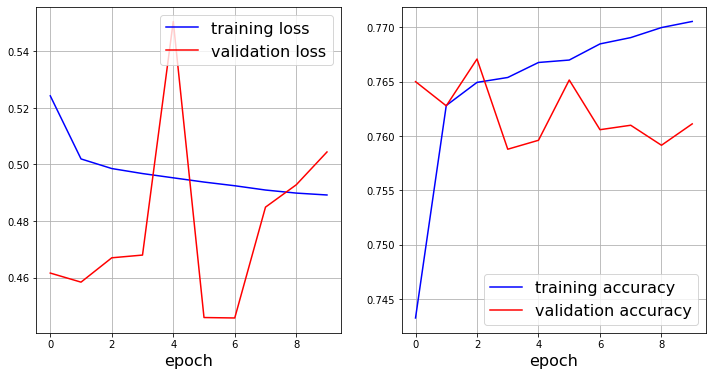

You can train the model for more than 10 epochs and see if you can get a better result

In [32]:
#to change the learning rate during traning, we may do this
for g in optimizer.param_groups:
    g['lr']=0.001

### after training, we load the best model from the harddrive and evaluate the model on the test set
You may get a different result because of random initialization of network parameters

In [33]:
# load the best model


In [34]:
#get the loss and accuracy on the test set


test loss: 0.44629325814592813
test accuracy 0.7520073
